In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "/Users/alexabartlett/class/python/build/lib.macosx-10.9-x86_64-3.9")
from classy import Class
import pyccl as ccl
import pyccl.nl_pt as pt
import numpy as np
import scipy as sc

plt.rcParams['axes.labelsize']        = 12
plt.rcParams['axes.titlesize']        = 12
plt.rcParams['xtick.labelsize']       = 12
plt.rcParams['ytick.labelsize']       = 12
plt.rcParams['font.family']           = 'serif'
plt.rcParams['font.size']             = 12


Reading in and defining relevant $dN/dz$ s, number densities, etc.

In [5]:
zarr = np.linspace(0, 4)

# DESI LRGs
desi_mu = 0.633
desi_std = 0.077
desi_dndz = np.exp(-((zarr-desi_mu)/(desi_std))**2)
desi_shotnoise = 1/(311 * 3282.8) # 2D shot noise
desi_b = 2
DESI_fsky = 0.4

# Rubin LSST
src_LSST = np.loadtxt('surveys/nz_lsst_5sbins.txt', unpack=True)
z_src_LSST = src_LSST[0]
dndz_src_LSST = src_LSST[-2]
neff_LSST = 5.54
sigma_eps_LSST = 0.26
LSST_fsky = 0.35
n_source_per_sterrad = neff_LSST * 60**2 * 41253 / (4 * np.pi)
shapenoise = sigma_eps_LSST**2 / n_source_per_sterrad

# SO Lensing
# Loading in SO noise curve
SO_noise = np.loadtxt('surveys/nlkk_v3_1_0deproj0_SENS2_fsky0p4_it_lT30-3000_lP30-5000.dat')
ell_SO = SO_noise[:,0]
all_SO = SO_noise[:,7]

# interpolating function for ease of computing variance later
SO_noise_interp = sc.interpolate.interp1d(ell_SO, all_SO)


Using CCL

In [ ]:
cosmo = ccl.Cosmology(Omega_c=0.25337, Omega_b=0.04933, h=0.68, sigma8=0.82, n_s=0.96, transfer_function='boltzmann_class')

# ell binning
def get_bins_and_geom_fac(fsky):
    dl = 30
    ellvec = []
    ellval = 30
    ellvec.append(ellval)
    dlvec = []
    fsky=0.4

    while ellval < 3000:
        dl = np.sqrt(900+10*ellval)
        ellval = (dl + ellval)
        ellvec.append(ellval)
        dlvec.append(dl)
        
    ellvec = np.array(ellvec)
    dlvec = np.array(dlvec)

    ellbins = (ellvec[1:] + ellvec[:-1])*0.5
    geom_fac = np.sqrt(2 / (fsky*dlvec*(2*ellbins + 1)))
    return ellbins, geom_fac

# Same fsky for DESI and SO
ellbins, geom_fac_DESI = get_bins_and_geom_fac(0.4)
ellbins, geom_fac_LSST = get_bins_and_geom_fac(0.35)


In [ ]:
ell = ellbins

ptt_m = pt.PTMatterTracer()
ptt_g = pt.PTNumberCountsTracer(b1=2.00)

ptc = pt.EulerianPTCalculator(with_NC=True, with_IA=False, log10k_min=-4, log10k_max=2, nk_per_decade=20)

ptc.update_ingredients(cosmo)

pk_gg = ptc.get_biased_pk2d(ptt_g, tracer2=ptt_g)
pk_gm = ptc.get_biased_pk2d(ptt_g, tracer2=ptt_m)
pk_mm = ptc.get_biased_pk2d(ptt_m, tracer2=ptt_m)

# bias handled in ptt_g
t_g = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(zarr, desi_dndz), bias=(zarr, np.ones_like(zarr)), mag_bias=None)
t_source = ccl.WeakLensingTracer(cosmo, dndz=(z_src_LSST, dndz_src_LSST))
t_cmb = ccl.CMBLensingTracer(cosmo, z_source=1088)

# clustering
clgg_DESI = ccl.angular_cl(cosmo, t_g, t_g, ell, p_of_k_a=pk_gg)

# CMB Lensing
clkg_cmb = ccl.angular_cl(cosmo, t_g, t_cmb, ell, p_of_k_a=pk_gm)
clkk_cmb = ccl.angular_cl(cosmo, t_cmb, t_cmb, ell, p_of_k_a=pk_mm)

# GGL and Shear
clkg_gal = ccl.angular_cl(cosmo, t_g, t_source, ell, p_of_k_a=pk_gm)
clkk_gal = ccl.angular_cl(cosmo, t_source, t_source, ell, p_of_k_a=pk_mm)


In [9]:
# For secondary k-axis
chi = 0.68*ccl.background.comoving_radial_distance(cosmo, 1/(1+desi_mu))

def k2ell(k):
    return k*chi - 0.5

def ell2k(ell):
    return (ell+0.5)/chi


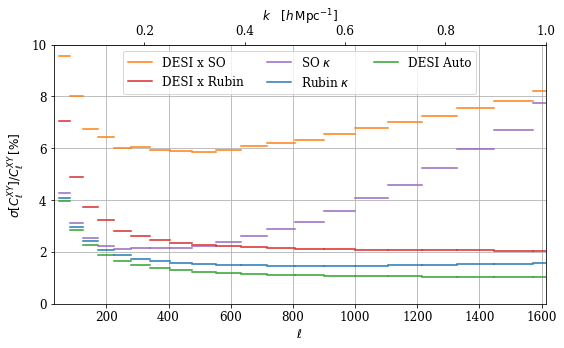

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

delta_ell = np.sqrt(900+10*ell) # intermediate binning between logarithmic and linear

# Fractional error (excluding geometric factors, handled below)
clkg_CMB_err = np.sqrt(1+(clkk_cmb+SO_noise_interp(ell))*(clgg_DESI+desi_shotnoise)/(clkg_cmb)**2)
clkg_gal_err = np.sqrt(1+(clkk_gal+shapenoise)*(clgg_DESI+desi_shotnoise)/(clkg_gal)**2)
clkk_cmb_err = (1 + SO_noise_interp(ell)/clkk_cmb)
clkk_rubin_err = 1 + shapenoise/clkk_gal
clgg_err = 1 + desi_shotnoise/(clgg_DESI)

for i in range(len(ellbins)-1):
    ax.plot([ellbins[i], ellbins[i+1]], [(100*geom_fac_DESI*clkg_CMB_err)[i]/np.sqrt(2), (100*geom_fac_DESI*clkg_CMB_err)[i]/np.sqrt(2)], c='C1')
    ax.plot([ellbins[i], ellbins[i+1]], [(100*geom_fac_LSST*clkg_gal_err)[i]/np.sqrt(2), (100*geom_fac_LSST*clkg_gal_err)[i]/np.sqrt(2)], c='C3')
    ax.plot([ellbins[i], ellbins[i+1]], [(100*geom_fac_DESI*clkk_cmb_err)[i], (100*geom_fac_DESI*clkk_cmb_err)[i]], color='C4')
    ax.plot([ellbins[i], ellbins[i+1]], [(100*geom_fac_LSST*clkk_rubin_err)[i], (100*geom_fac_LSST*clkk_rubin_err)[i]], color='C0')
    ax.plot([ellbins[i], ellbins[i+1]], [(100*geom_fac_DESI*clgg_err)[i], (100*geom_fac_DESI*clgg_err)[i]], c='C2')

ax.legend([r'DESI x SO', r'DESI x Rubin', r'SO $\kappa$', r'Rubin $\kappa$', r'DESI Auto'], ncol=3)
ax.set_ylim(0, 10)
ax.grid(True)
ax.set_xlim(30, 1*chi-0.5)
ax.set_xlabel(r'$\ell$', fontsize=12)
ax.set_ylabel(r'$\sigma[C_{\ell}^{XY}]/C_{\ell}^{XY}\,[\%]$', fontsize=12)

secax = ax.secondary_xaxis('top', functions=(ell2k, k2ell))
secax.set_xlabel(r'$k\quad[h\,{\rm Mpc}^{-1}]$')

plt.tight_layout()
plt.savefig('figures/frac_stat_err.pdf')


Other Figures

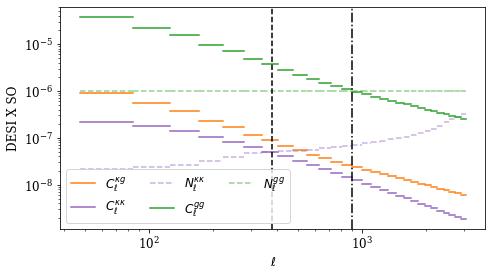

In [16]:
plt.figure(figsize=(7,4))

for i in range(len(ellbins)-1):
    plt.plot([ellbins[i], ellbins[i+1]], [clkg_cmb[i], clkg_cmb[i]], c='C1')

    plt.plot([ellbins[i], ellbins[i+1]], [clkk_cmb[i], clkk_cmb[i]], color='C4')
    plt.plot([ellbins[i], ellbins[i+1]], [SO_noise_interp(ellbins[i]), SO_noise_interp(ellbins[i])], color='C4', alpha=0.5, ls='--')

    plt.plot([ellbins[i], ellbins[i+1]], [clgg_DESI[i], clgg_DESI[i]], c='C2')
    plt.plot([ellbins[i], ellbins[i+1]], [desi_shotnoise, desi_shotnoise], c='C2', alpha=0.5, ls='--')


plt.axvline(380, color='k', ls='--')
plt.axvline(900, color='k', ls='-.')
# plt.axhline(7e-7)
plt.legend([r'$C_\ell^{\kappa g}$', r'$C_\ell^{\kappa \kappa}$', r'$N_\ell^{\kappa \kappa}$', r'$C_\ell^{gg}$', r'$N_\ell^{gg}$'], ncol=3)
plt.xlabel(r'$\ell$')
plt.ylabel('DESI X SO')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()



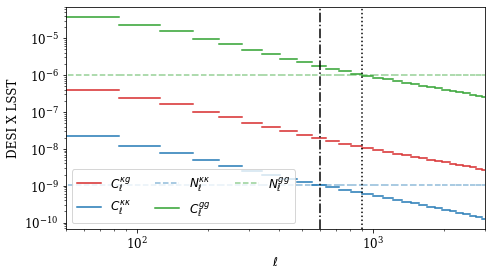

In [18]:
plt.figure(figsize=(7,4))

for i in range(len(ellbins)-1):
    plt.plot([ellbins[i], ellbins[i+1]], [clkg_gal[i], clkg_gal[i]], c='C3')

    plt.plot([ellbins[i], ellbins[i+1]], [clkk_gal[i], clkk_gal[i]], color='C0')
    plt.plot([ellbins[i], ellbins[i+1]], [shapenoise, shapenoise], color='C0', alpha=0.5, ls='--')

    plt.plot([ellbins[i], ellbins[i+1]], [clgg_DESI[i], clgg_DESI[i]], c='C2')
    plt.plot([ellbins[i], ellbins[i+1]], [desi_shotnoise, desi_shotnoise], c='C2', alpha=0.5, ls='--')

plt.axvline(600, color='k', ls='-.')
plt.axvline(900, color='k', ls=':')
plt.xlim(50,3e3)
plt.legend([r'$C_\ell^{\kappa g}$', r'$C_\ell^{\kappa \kappa}$', r'$N_\ell^{\kappa \kappa}$', r'$C_\ell^{gg}$', r'$N_\ell^{gg}$'], ncol=3, loc='lower left')
plt.xlabel(r'$\ell$')
plt.ylabel('DESI X LSST')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()